# CSCI-UA 0480-042 Computer Vision
## Homework 3

Enter your name and NetID below.

#### Name: Sage Bergerson
#### NetID: sab9835

The main goals of this assignment include:

1. Giving an introduction to Mask-RCNN
2. Training the predictors for a given dataset
3. Finetuning the entire network for the same dataset

Also accompanying each part, there are a few questions (**12 questions in total**) -- 11 mandatory + 1 extra credit. The first 11 questions are worth 100 points and the extra credit question is worth 10 points. 

Please give your answers in the space provided. This homework has a mix of conceptual and coding questions. You can quickly navigate to coding questions by searching (Ctrl/Cmd-F) for `TODO:`. 

# 1. Introduction to Mask-RCNN

[Mask-RCNN](https://arxiv.org/pdf/1703.06870.pdf) is a network used for instance segmentation. Instance segmentation can be thought of as a hybrid of semantic segmentation and object detection. In other words, we don't want to just find the bounding boxes for each object in our image, we're also interested in finding the segmentation mask of *each object instance*.

![Instance Segmentation as a Hybrid of Semantic Segmentation and Object Detection](../shared/HW3/img/instance_segmentation.png)

Image Credits: https://towardsdatascience.com/single-stage-instance-segmentation-a-review-1eeb66e0cc49

Mask-RCNN is built on top of Faster-RCNN, which is a network used for object detection. Faster-RCNN has 2 outputs for each candidate object (Region of Interest or RoI) - a class label and a bounding box offset. Mask-RCNN adds a third branch to Faster-RCNN for predicting segmentation masks on each RoI.

We'll first briefly go over Faster-RCNN. Faster-RCNN has 2 stages:

1. **Region Proposal Network (RPN):** Given the image, it proposes candidate object bounding boxes. Previous object detection models such as RCNN and Fast-RCNN handled this separately from the CNN model. Faster-RCNN takes a different approach -- it integrates these two components into the same network to achieve speedup.
2. **Fast-RCNN:** This stages takes each candidate RoI and extracts features from the image feature vector using RoIPool. Using these RoI features, it performs classification and bounding box regression.

![Mask-RCNN framework for instance segmentation](../shared/HW3/img/mask_rcnn_architecture.png)

Mask-RCNN has the same 2-stage procedure, but in the 2nd stage, instead of just predicting the classification label and the bounding box offset, it predicts **in parallel** a binary mask for each RoI. 

Mask-RCNN relies on a pretrained network (called the "backbone" in the paper) to extract features from the image. These features are fed into the Region Proposal Network (RPN) to generate candidate RoIs. For each RoI candidate, a fixed size RoI feature vector is generated using an RoIAlign layer. This RoI feature map is then provided to the classifier, bounding box predictor and the segmentation mask to generate the final output.

## Question 1 [10%]

Training uses a multi-task loss function. What are the three components in this loss function? Is the loss computed per image or per RoI?

#### Answer :   

The loss function is defined as: $L = L_{cls} + L_{box} + L_{mask}$ in which $L_{cls}$ is the classification loss, $L_{box}$ is the bounding-box loss, and $L_{mask}$ is the segmentation mask loss. Loss is computed per RoI.

## Question 2 [5%]
[This blog post](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html) by Lilian Weng gives a nice overview of the object detection (RCNN type) networks. In the blog post, it is mentioned that Mask-RCNN uses RoIAlign instead of RoIPool. Explain briefly in 3-4 lines why this is being done.

#### Answer :  

Mask-RCNN uses RoIAlign to improve the RoI pooling layer (instead of using RoIPool) in order to more accurately map RoIs determined by the network to regions of the original image. Using RoIAlign fixes location misalignment caused by quantization (compression of a range of values into a discrete value) during RoI pooling. This is useful because pixel-level segmentation requires more fine-grained alignment than bounding boxes.

## Question 3 [5%]
What are the different backbones explored in the Mask-RCNN paper? They are denoted in the paper using network-depth-features nomenclature. What is the advantage of using a ResNet-FPN backbone over a ResNet-C4 backbone for feature extraction?

#### Answer :

ResNet-50-C4  
ResNet-101-C4  
ResNet-50-C5  
ResNet-50-FPN  
ResNet-101-FPN  
ResNeXt-101-FPN  
ResNeXt-152-FPN
ResNext-152-FPN-NL  
  
A ResNet-FPN backbone uses a top-down architecture with lateral connections to build an in-network feature pyramid from a single-scale input. In this way, using a ResNet-FPN backbone for feature extraction in combination with Mask-RCNN increases performance in accuracy and speed.

# 2. Training the Predictors for a New Dataset

In this section, we'll start with a pretrained Mask-RCNN model that uses Resnet-50-FPN as the backbone. This model was trained on MS-COCO dataset which is widely used for multiple vision tasks such as object detection, instance segmentation, etc.

MS-COCO has 91 classes (90 for objects + 1 for background). Some sample objects in the dataset include `person`, `car`, `bicycle`, `knife`, `train`, etc. 

Along with this homework file, we have also provided another sample dataset (we'll refer to it as the [Nature dataset](https://towardsdatascience.com/custom-instance-segmentation-training-with-7-lines-of-code-ff340851e99b)). It isn't a standard dataset, but it's small enough (600 train + 200 test images) and allows us to easily demo finetuning a pretrained Mask-RCNN model. This dataset contains only 2 classes - `squirrel` and `butterfly`. 

Our goal in part2 and part3 of this assignment is to take the pretrained Mask-RCNN model and finetune/train it for this dataset. However, here in part2, instead of finetuning the entire network, we'll train only the final layers.

In Homework 2, we've shown how one could feed data into the network using `Dataset`s and `DataLoader`s. We'll use the same strategy here for finetuning the model.

We've based this homework on this [PyTorch tutorial on Object Detection Finetuning](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

## Question 4 [25%]

Complete the TODO section in below cell. Specifically:

1. Read image height, width and polygon shapes data from the JSON file.
2. Generate 2D masks from the polygon points. You can follow this idea: https://stackoverflow.com/a/3732128
3. Generate the bounding boxes from the mask data. Assume that the bounding box is a rectangle with the smallest area enclosing the mask.

You may find this json schema useful:
```
{
   "shapes": [ # list of object instances; masks are represented as polygons
       ## data for instance1 
       {
           "label": "" # label for instance1
           "points": [] # 2d list of polygon points [(x1, y1), (x2, y2), ..]
       },
       ## data for instance2
       {
           "label": []
           "points": []
       },
       
       ..
       ..
   ],
   "imagePath": ""
   "imageData" : ""
   "imageHeight": <integer>
   "imageWidth": <integer>
}
```

In [1]:
# Alternatively, you could also uncomment the line below to see a sample json file
!cat '../shared/data/HW3/nature/train/s (3).json'


















































































































































































































































































































































































































































































}

In [25]:
import numpy as np
import torch
import torchvision

import json # for reading from json file
import glob # for listing files inside a folder
from PIL import Image, ImageDraw # for reading images and drawing masks on them.


# Create a custom dataset class for Nature
# dataset subclassing PyTorch's Dataset class
class NatureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.transforms = transforms

        # Load all image files, sorting them to
        # ensure that they are aligned with json files
        imgs = glob.glob(root + '/*.jpg')
        imgs += glob.glob(root + '/*.png') # some images are in png format
        self.imgs = sorted(imgs)
        
        # Mask data is stored in a json file
        masks = glob.glob(root + '/*.json')
        self.masks = sorted(masks)

        # Each image can have multiple object instances, and each
        # instance is associated with either of these 2 labels.

        # Need to convert str-labels to ids. So we'll use 
        # this label-to-index mapping.
        # Note: we can't start from 0 because 0 is restricted
        # to the "background" class
        self.label_to_id = {'squirrel': 1, 'butterfly': 2}

        
    def __getitem__(self, idx):
        # Have already aligned images and JSON files; can now
        # simply use the index to access both images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        
        # Read image using PIL.Image and convert it to an RGB image
        img = Image.open(img_path).convert("RGB")
        
        # TODO: Read image height, width and mask data from
        # the JSON file
        with open(mask_path, 'r') as fp:
            # TODO: Using json library read the dictionary
            # from the fp
            json_dict = json.load(fp)
            
            # TODO:
            height = json_dict.get('imageHeight')
            
            # TODO:
            width = json_dict.get('imageWidth')
            
            # TODO:
            poly_shapes_data = json_dict.get('shapes')
        
        # TODO: Each image can have multiple mask instances.
        # Using the polygon points, generate the 2d-mask
        # using PIL's ImageDraw.polygon
        masks = []
        labels = []
        for shape_data in poly_shapes_data:
            polygon_points = [tuple(point) for point in shape_data['points']]
            
            # TODO: Using Image.new() create an image of size (width, height)
            # and fill it with 0s.
            mask_img = Image.new(mode='1', size=(width, height))
            
            # TODO: Draw the mask on the base image we just created
            ImageDraw.Draw(mask_img).polygon(polygon_points, outline=1, fill=1)

            mask = np.array(mask_img)
            masks.append(mask)

            label = shape_data['label']
            labels.append(label)
        
        # Each mask instance also has an associated label which is str-type
        # Convert the str into an int using the mapping we created in __init__
        labels = [self.label_to_id[label] for label in labels]
        
        # TODO: Generate the bounding boxes for each instance
        # from the 2d masks
        num_objs = len(masks)

        boxes = []
        for i in range(num_objs):
            # TODO: Use np.where() to find where mask[i] == True.
            # pos will be a 2d-list of indices
            pos = np.where(masks[i] == True)
            
            # In pos, find the min x- and y- indices;
            # max x- and y- indices. This will give us our box bounds.
            
            # TODO:
            xmin = np.min(pos[1])
            
            # TODO:
            xmax = np.max(pos[1])
            
            # TODO:
            ymin = np.min(pos[0])
            
            # TODO:
            ymax = np.max(pos[0])
            
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # Apply transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    
    def __len__(self):
        return len(self.imgs)

Having implemented our `NatureDataset` class, let's create the `Dataset` and the `DataLoader` objects. Note that we're not using `torchvision.transforms`, instead we're using transforms provided in a separate script in this directory called `transforms.py`.

In [26]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = NatureDataset('../shared/data/HW3/nature/train', get_transform(train=True))
dataset_test = NatureDataset('../shared/data/HW3/nature/test', get_transform(train=False))

import utils

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

Now let's visualize one image from our dataset.

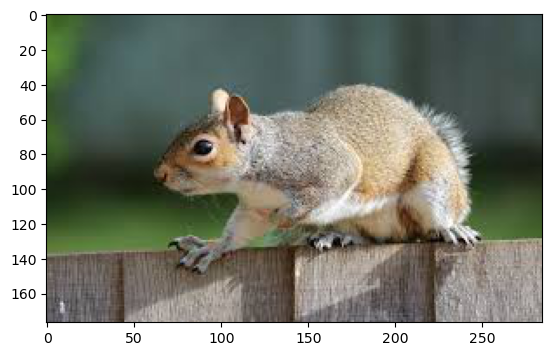

In [27]:
import matplotlib.pyplot as plt

img, targets = dataset[506]

# np.transpose docs: https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
# img is a PyTorch tensor, can convert it to a NumPy tensor by calling .numpy() on it.
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));

And here's the corresponding mask.

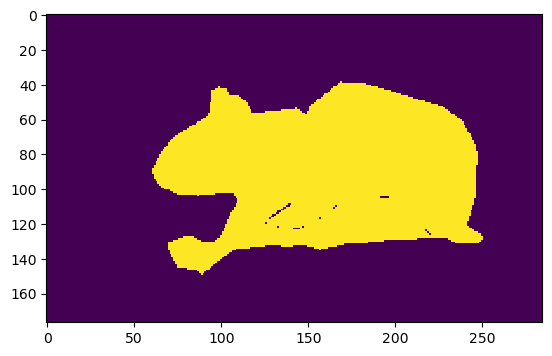

In [30]:
plt.imshow(np.transpose(targets['masks'].numpy(), (1, 2, 0)), interpolation='none');

We'll be training the final layers of the pretrained Mask-RCNN model (with Resnet-50-FPN backbone) available in the `torchvision` package. So let's download the model:

In [31]:
model_p2 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Question 5 [5%]

Recall what we said earlier: For training for the new dataset, we need to modify its box predictor (FastRCNNPredictor) and its mask predictor (MaskRCNNPredictor) to match with the new dataset. Complete the code cell below.

You may find these docs for `FastRCNNPredictor` and `MaskRCNNPredictor` useful:

![FastRCNNPredictor Docs](../shared/HW3/img/FastRCNNPredictor_docs.png)
![MaskRCNNPredictor Docs](../shared/HW3/img/MaskRCNNPredictor_docs.png)

In [32]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Our new dataset has 3 classes: butterfly, squirrel and background
num_classes = 3

# Get number of input features for the classifier
in_features = model_p2.roi_heads.box_predictor.cls_score.in_features

# TODO: replace the pre-trained head with a new one
model_p2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Get number of input features for the mask predictor
in_features_mask = model_p2.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# TODO: replace the mask predictor with a new one
model_p2.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

Training these layers can take several minutes on a CPU, so we've provided GPUs to make this faster. It should take ~5 mins to run the training in Q7. But before that, we want to ensure that PyTorch is able to access the GPU by printing the device PyTorch is currently (prints `cuda` if it's using a GPU, otherwise it prints `cpu`). 

Now we want to freeze all the layers below these predictors. We can do this by setting the `.requires_grad` attribute of the parameters we want to freeze to `False`. Read more about `requires_grad` from [this PyTorch page on Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html#excluding-subgraphs-from-backward).

In order to do the computation on a GPU, we have to move the model from main memory to GPU memory. This can be done by simply calling `.to(device)` on the model. See [the docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) for more information.

### Note : Make sure the below prints `Using : cuda` before proceeding further. If it doesn't print cuda , make sure you are in the GPU profile of the server. To start the server in GPU profile, shutdown the current server and restart the server by selecting the GPU option. 

In [33]:
import itertools

# Freeze model and move it to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using : ", device)

for param in model_p2.parameters():
    param.requires_grad = False

pred_params = itertools.chain(
    model_p2.roi_heads.mask_predictor.parameters(),
    model_p2.roi_heads.box_predictor.parameters()
)

for param in pred_params:
    param.requires_grad = True

model_p2 = model_p2.to(device)

Using :  cuda


We were able to verify that PyTorch is able to access a GPU. Now let's see the layers inside the `model_p2.roi_heads` to understand what we have modified here (we just modified `box_predictor` and `mask_predictor`). You could also verify the output below from figure 4 in the Mask-RCNN paper. You'll notice that it's the exact same network on the right part of that figure.

We can use below command to check what are the GPU devices that are available to us and their current memory usage. Having a GPU in the list doesn't mean we can simply use it for training. We need to have proper CUDA drivers and compatible versions of pytorch/torchvision libraries. We have made sure that the versions are compatible and one is able to use GPU without and additional changes. 

In [34]:
!nvidia-smi

Fri Nov 18 14:10:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    758MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
model_p2.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=3, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

## Question 6 [10%]
We just printed the head architecture. From the above output, list all the layers we're training along their names. 

For example, if we're training mask_fcn1 of mask_head you'll specify:

`mask_head.mask_fcn1`: 2d-Conv layer with 256 input channels, 256 output channels and kernel size = (2, 2).

Note: We're **only** asking for layers with trainable parameters.

#### Answer :

box_predictor.cls_score: Linear layer, 1024 input features, 3 output features, bias  
box_predictor.bboxhead: Linear layer, 1024 input features, 12 output features, bias   
mask_predictor.conv5_mask: 2d-Conv layer, 256 input channels, 256 output channels, kernel size 2, stride 2  
mask_predictor.mask_fcn_logits: 2d-Conv layer,  256 input channels, 3 output channels, kernel size 1, stride 1  

Both the dataloaders and model have been prepared for training. All that remains is to set an optimizer and a learning rate scheduler. When we create an optimizer, we have to provide it the list of trainable parameters.

In [36]:
# Declare optimizer and lr
params = [p for p in model_p2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [53]:
print(params[0].shape)

torch.Size([128, 256, 1, 1])


## Question 7 [10%]

How many trainable parameters are we passing to the optimizer?

Here's an example to calculate # of trainable parameters in a fully connected layer with:
1. an additive bias
2. in_channels = 1024
3. out_channels = 10

The number of trainable parameters here will be 1024\*10 + 10 = 10250.

#### Answer :

$((1024 \cdot 3)+3) + ((1024 \cdot 12)+12) + (2^2 \cdot 256 + 1) \cdot 256 + ((1^2 \cdot 256 + 1) \cdot 3 = 3075 + 12300 + 262,400 + 771 = 278546$

Total trainable parameters: 278,546

In [54]:
pytorch_total_params = sum(p.numel() for p in model_p2.roi_heads.parameters() if p.requires_grad)
print(pytorch_total_params)

278546


Now we can finally start the training process.

In [38]:
num_epochs = 3

from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    print("Epoch", epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_p2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_p2, data_loader_test, device=device)

Epoch 0
Epoch: [0]  [  0/300]  eta: 0:19:09  lr: 0.000022  loss: 3.5947 (3.5947)  loss_classifier: 0.8301 (0.8301)  loss_box_reg: 0.1056 (0.1056)  loss_mask: 2.6484 (2.6484)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 3.8305  data: 0.0302  max mem: 820
Epoch: [0]  [ 10/300]  eta: 0:02:49  lr: 0.000189  loss: 3.7720 (3.7955)  loss_classifier: 0.7432 (0.7624)  loss_box_reg: 0.1556 (0.1486)  loss_mask: 2.8600 (2.8722)  loss_objectness: 0.0019 (0.0029)  loss_rpn_box_reg: 0.0081 (0.0093)  time: 0.5840  data: 0.0262  max mem: 1218
Epoch: [0]  [ 20/300]  eta: 0:02:01  lr: 0.000356  loss: 1.7372 (2.6084)  loss_classifier: 0.4733 (0.5339)  loss_box_reg: 0.1455 (0.1414)  loss_mask: 1.3849 (1.9163)  loss_objectness: 0.0020 (0.0041)  loss_rpn_box_reg: 0.0081 (0.0127)  time: 0.2656  data: 0.0258  max mem: 1593
Epoch: [0]  [ 30/300]  eta: 0:01:42  lr: 0.000523  loss: 1.1028 (2.1742)  loss_classifier: 0.1718 (0.4006)  loss_box_reg: 0.1142 (0.1345)  loss_mask: 0.7922 (1

In order to analyze the output, you'll need to know what an IoU score is. You can read this blog: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

## Question 8 [10%]

In an image (grey box) of size 12x16, there is an object whose ground truth mask is the box with the dashed edge (green color) and the model's predicted mask is the box with the dash-dotted edge (red color). Calculate the IoU score for this prediction.

![Image](../shared/HW3/img/plot.png)

#### Answer :

IoU = Intersection/Union  
Intersection = $4 \cdot 5 = 20$  
Union = $5 \cdot 7 + 1 \cdot 5 = 35 + 5 = 40$  
Intersection/Union = $20/40 = 0.5$  

Let's see the model's prediction for a sample from the test set.

In [39]:
img, target = dataset_test[1]

# put the model in evaluation mode
model_p2.eval()

with torch.no_grad():
    prediction = model_p2([img.to(device)])

Here's the sample image.

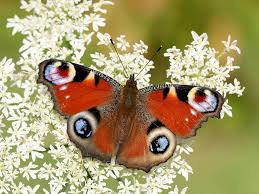

In [40]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And here's the mask generated by the finetuned model.

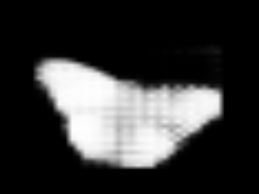

In [41]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

# 3. Finetuning the Entire Network

Let's see what happens when we fine-tune the entire network. That is, instead of just learning the weights in the final layers, we'll let the weights of the entire network change during the training process.

In [42]:
model_p3 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

## Question 9 [5%]

Just like in question 5, we're interested in fine-tuning the pretrained model for our new dataset, so we will again need to modify its box predictor (FastRCNNPredictor) and its mask predictor (MaskRCNNPredictor) to match with our new dataset. Complete the code cell below. Hint: This is exactly the same as question 5.

In [43]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Our new dataset has 3 classes: butterfly, squirrel and background
num_classes = 3

# Get number of input features for the classifier
in_features = model_p3.roi_heads.box_predictor.cls_score.in_features

# TODO: replace the pre-trained head with a new one
model_p3.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Get number of input features for the mask predictor
in_features_mask = model_p3.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# TODO: replace the mask predictor with a new one
model_p3.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

Again, let's ensure that we're using the GPU by printing the device info. This finetuning process takes even longer because we have more trainable parameters, hence there will be more computations.

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using : ", device)

model_p3 = model_p3.to(device)

Using :  cuda


We'll use the same optimizer and learning rate scheduler as before.

In [45]:
params = [p for p in model_p3.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

Let's start the finetuning process.

In [46]:
num_epochs = 3

from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    print("Epoch", epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_p3, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_p3, data_loader_test, device=device)

Epoch 0
Epoch: [0]  [  0/300]  eta: 0:03:31  lr: 0.000022  loss: 3.0915 (3.0915)  loss_classifier: 0.9978 (0.9978)  loss_box_reg: 0.1491 (0.1491)  loss_mask: 1.9277 (1.9277)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 0.7048  data: 0.0272  max mem: 2742
Epoch: [0]  [ 10/300]  eta: 0:03:03  lr: 0.000189  loss: 2.7651 (2.6398)  loss_classifier: 0.8147 (0.7693)  loss_box_reg: 0.1386 (0.1399)  loss_mask: 1.6250 (1.7107)  loss_objectness: 0.0039 (0.0057)  loss_rpn_box_reg: 0.0082 (0.0142)  time: 0.6343  data: 0.0254  max mem: 4590
Epoch: [0]  [ 20/300]  eta: 0:02:56  lr: 0.000356  loss: 1.3139 (1.7949)  loss_classifier: 0.2710 (0.4847)  loss_box_reg: 0.1276 (0.1390)  loss_mask: 0.7392 (1.1511)  loss_objectness: 0.0039 (0.0054)  loss_rpn_box_reg: 0.0065 (0.0147)  time: 0.6275  data: 0.0252  max mem: 4590
Epoch: [0]  [ 30/300]  eta: 0:02:52  lr: 0.000523  loss: 0.7051 (1.4572)  loss_classifier: 0.1246 (0.3672)  loss_box_reg: 0.1181 (0.1361)  loss_mask: 0.4109 (

We'll generate the output for the same image, but this time with the new finetuned model.

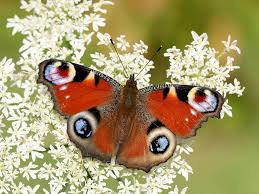

In [48]:
img, target = dataset_test[1]

# put the model in evaluation mode
model_p3.eval()
with torch.no_grad():
    prediction = model_p3([img.to(device)])

Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Here's the predicted image.

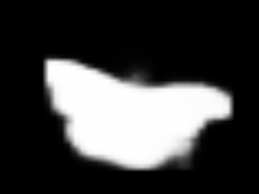

In [49]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

## Question 10 [5%]

Does this model perform better than the trained model after Q7? Explain why.

#### Answer : 

Yes, it does perform better as evidenced by the crisper definition of the outline of the butterfly as the more completely filled in central portion. In the trained model after Q7 we had only been able to fine two the last two layers, whereas in the model after Q9, we were able to fine tune all layers. This means we were able to update more of the model's parameters to the current task.

## Question 11 [10 %]

What is the advantage of using CONV layers over FC/Dense layers?

#### Answer :

Convolutions are not densely connected, meaning that not all input nodes will affect all output nodes. This gives convolutional layers more flexibility during learning. This also means that the number of weights will be much smaller, which is ideal for handling high-dimensional data, i.e. images. 

# 4. Extra Credit Questions

## Question 12 [10 points]

Can fully convolutional networks (FCN) be used for object detection? In Mask-RCNN we have 3 branches — mask, classification, and bounding box regression — out of which the last 2 have fully connected (FC) layers. Can this entire pipeline be replaced by a fully convolutional network? If possible, give 1 or 2 networks to support your claim.

#### Answer :

Yes, fully convolutional networks (FCNs) can be used for obejct detection.   
  
For example, Long, Shelhamer & Darrell [1], adapt three well-known classification networks into FCN-AlexNet, FCN-VGG net, and FCN-GoogLeNet into FCNs. Dai et al. also develop a region-based FCN [2]. All of the above networks acheive competetive results on object detection benchmarks.   

[1] https://arxiv.org/pdf/1411.4038.pdf  
[2] https://papers.nips.cc/paper/2016/file/577ef1154f3240ad5b9b413aa7346a1e-Paper.pdf